# Commodity crush spread statistical arbitrage

This notebook investigates the analysis done in Simon 1999 which is about the crush spread in soybean complex. The crush spread in soybean (soybean, soybean mean and soybeam oil) appears to be mean-reverting both in the short-term and long-term. The author suggests to employ a mean-reversion strategy to capture this price pattern.

In [1]:
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import pytz
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('bmh')

from vivace.backtest import signal
from vivace.backtest.analytics import rebase
from vivace.backtest.contract import InstrumentDef
from vivace.backtest.engine import BacktestEngine
from vivace.backtest.stats import Performance
from vivace.enums import Strategy, Weighting

# The soybean crush spread

## USDA estimates 1988

First we get the generic price time-series of the front contracts for soybean, meal and oil.

In [2]:
soybean_1st = BacktestEngine(instrument='S', log_level=logging.WARN)
soybean_1st.run()

In [3]:
soybean_meal_1st = BacktestEngine(instrument='SM', log_level=logging.WARN)
soybean_meal_1st.run()

In [4]:
soybean_oil_1st = BacktestEngine(instrument='BO', log_level=logging.WARN)
soybean_oil_1st.run()

In [5]:
soybean_price = soybean_1st.get_generic_price()
soybean_meal_price = soybean_meal_1st.get_generic_price()
soybean_oil_price = soybean_oil_1st.get_generic_price()

Note that each futures prices use different units. *Ignoreing the inherent leverage* in the futures contracts, they each are priced in the following units:
- Soybean meal price is per 1 ton
- Soybean oil price is per 100 pounds
- Soybean price is per 100 bushels

In [6]:
gcm = (soybean_meal_price.squeeze().div(2000).mul(48) + 
       soybean_oil_price.squeeze().div(100).mul(11) - 
       soybean_price.squeeze().div(100))

The chart below reproduces the gross crush margin estimated by USDA 1988.

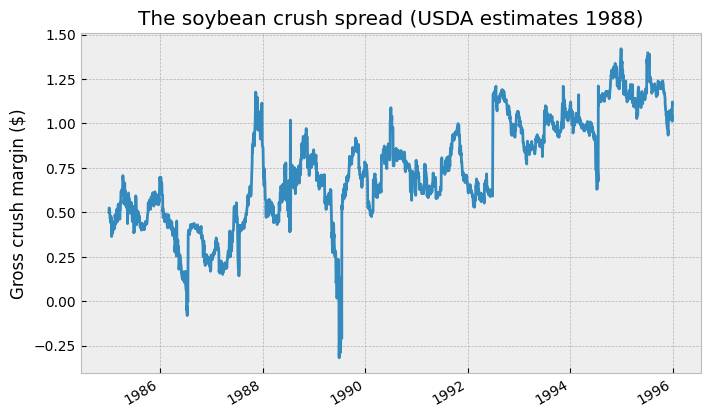

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
gcm['1985':'1995'].plot(ax=ax);
ax.set_ylabel('Gross crush margin ($)')
ax.set_title('The soybean crush spread (USDA estimates 1988)');

The next chart shows a long-term perspective. As mentioned in Simon 1999, this spread does not necessarily represent a long-run equilibrium because the amount of mean and oil can vary depending on the growing condition.

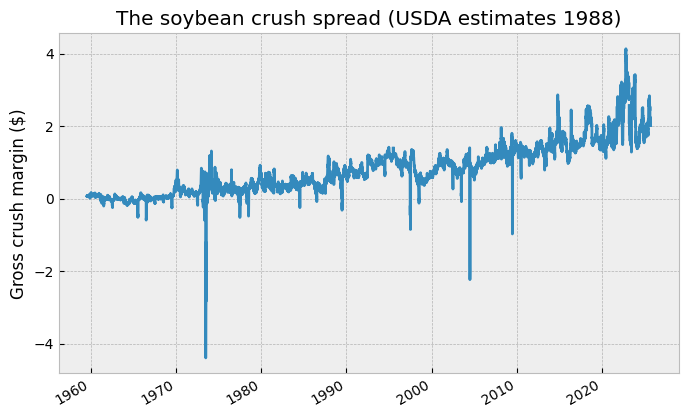

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
gcm.plot(ax=ax);
ax.set_ylabel('Gross crush margin ($)')
ax.set_title('The soybean crush spread (USDA estimates 1988)');

## Long-run equilibrium

In [9]:
price_concat = pd.concat((
    soybean_meal_price,
    soybean_oil_price,
    soybean_price.div(100),
), axis=1).fillna(method='pad').dropna()

In [10]:
month_dummies = pd.get_dummies(pd.Series(price_concat.index.month, index=price_concat.index))
month_dummies = month_dummies.drop(12, axis=1).add_prefix('month_').astype(int)
trend = pd.Series(range(len(price_concat)), index=price_concat.index, name='trend')

In [11]:
ols_data = pd.concat((price_concat, trend, month_dummies), axis=1)

In [12]:
ols_y = ols_data['S']
ols_x = sm.add_constant(ols_data.drop('S', axis=1))

In [13]:
ols_model = sm.OLS(ols_y.loc['1985':'1995-02'], 
                   ols_x.loc['1985':'1995-02'])
ols_results = ols_model.fit()

The result below is broadly in line with the table 2 in Simon 1999. There is a strong seasonality in this result where the crush spread tends to be lower in the growing season from February to June, while it tends to be higher in September to November. This can be attributed to the relative scarcity in soybeans during the growing season.

In [14]:
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     7218.
Date:                Fri, 26 Sep 2025   Prob (F-statistic):               0.00
Time:                        10:40:34   Log-Likelihood:                 1414.4
No. Observations:                2565   AIC:                            -2799.
Df Residuals:                    2550   BIC:                            -2711.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6342      0.032     51.199      0.000       1.572       1.697
SM             0.0237   9.37e-05    253.360      0.000       0.024       0.024
BO             0.0880      0.001    115.074      0.000       0.087       0.090
trend         -0.0002   4.05e-06    -60.761      0.000      -0.000      -0.000
month_1        0.0669      0.013      5.027      0.000       0.041       0.093
month_2        0.1375      0.014     10.067      0.000       0.111       0.164
month_3        0.1551      0.014     11.457      0.000       0.129       0.182
month_4        0.1762      0.014     12.806      0.000       0.149       0.203
month_5        0.1766      0.014     12.911      0.000       0.150       0.203
month_6        0.2092      0.014     15.363      0.000       0.182       0.236
month_7        0.1252      0.014      9.194      0.000       0.098       0.152
month_8        0.0224      0.013      1.668      0.096      -0.004       0.049
month_9       -0.0155      0.014     -1.132      0.258      -0.042       0.011
month_10      -0.0753      0.014     -5.570      0.000      -0.102      -0.049
month_11      -0.0603      0.014     -4.390      0.000      -0.087      -0.033
==============================================================================
Omnibus:                      350.535   Durbin-Watson:                   0.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2777.790
Skew:                           0.387   Prob(JB):                         0.00
Kurtosis:                       8.039   Cond. No.                     1.05e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For fun, let's run the same model but with more recent data of about the past 10 years.

In [15]:
ols_model = sm.OLS(ols_y.loc['2010':], 
                   ols_x.loc['2010':])
ols_results = ols_model.fit()

This suggests that there is still some seasonality but it became much weaker compared to the result above.

In [16]:
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 1.254e+04
Date:                Fri, 26 Sep 2025   Prob (F-statistic):               0.00
Time:                        10:40:35   Log-Likelihood:                -1414.4
No. Observations:                3961   AIC:                             2859.
Df Residuals:                    3946   BIC:                             2953.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3029      0.082     40.293      0.000       3.142       3.464
SM             0.0218      0.000    193.139      0.000       0.022       0.022
BO             0.1043      0.001    193.553      0.000       0.103       0.105
trend         -0.0003   4.93e-06    -55.306      0.000      -0.000      -0.000
month_1        0.0471      0.027      1.718      0.086      -0.007       0.101
month_2        0.0580      0.028      2.087      0.037       0.004       0.112
month_3        0.0996      0.027      3.704      0.000       0.047       0.152
month_4        0.1530      0.027      5.617      0.000       0.100       0.206
month_5        0.1217      0.027      4.490      0.000       0.069       0.175
month_6        0.1607      0.027      5.924      0.000       0.107       0.214
month_7       -0.0816      0.027     -3.007      0.003      -0.135      -0.028
month_8       -0.1223      0.027     -4.557      0.000      -0.175      -0.070
month_9       -0.0469      0.027     -1.710      0.087      -0.101       0.007
month_10      -0.1711      0.027     -6.278      0.000      -0.225      -0.118
month_11      -0.1570      0.028     -5.657      0.000      -0.211      -0.103
==============================================================================
Omnibus:                      428.945   Durbin-Watson:                   0.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              607.060
Skew:                          -0.838   Prob(JB):                    1.51e-132
Kurtosis:                       3.933   Cond. No.                     2.29e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Trading strategy

## 1-1-1 crush spread

As opposed to the one estimated by USDA, or the cointegratioin model estimated by the author, often in practice the crush spread is quoted and traded with 1-1-1 contract sizes. Simon 1999 uses the spread with 100 tons of meal, 60,000 pounds of oil and 5000 bushel of soybeans. 

Incidentally this weighting is roughly equal to the one listed on CME (https://www.cmegroup.com/education/courses/introduction-to-agriculture/grains-oilseeds/understanding-soybean-crush.html), which is the spread with 4,400 pounds (2.2 ton) of meal, 1,100 pounds of oil and 100 bushel of soybeans. 

In [17]:
crush_spread = (soybean_meal_price.squeeze().mul(100) + 
                soybean_oil_price.squeeze().mul(600) - 
                soybean_price.squeeze().mul(50))

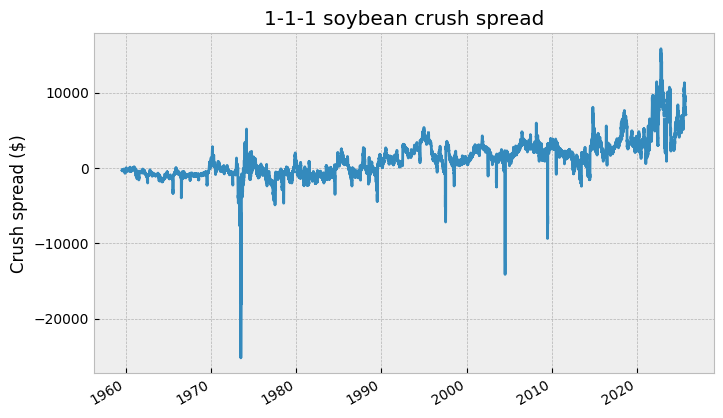

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
crush_spread.plot();
ax.set_ylabel('Crush spread ($)')
ax.set_title('1-1-1 soybean crush spread');

The spread appears mean-reverting around its 5-day moving average.

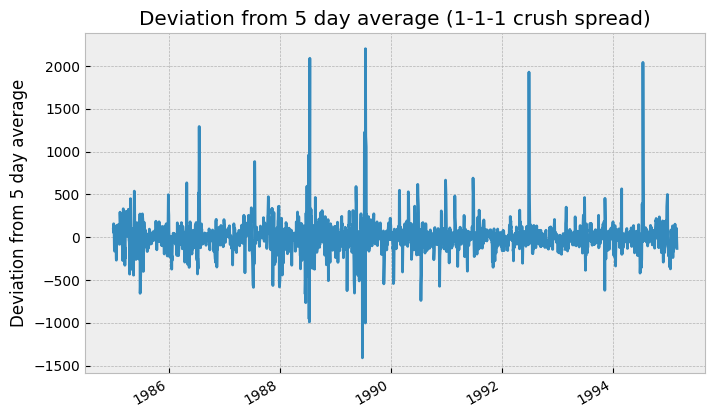

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
(crush_spread - crush_spread.rolling(5).mean())['1985-01':'1995-02'].plot(ax=ax);
ax.set_ylabel('Deviation from 5 day average')
ax.set_title('Deviation from 5 day average (1-1-1 crush spread)');

## Ref CME crush spread

For reference, the crush spread defined by CME follows about the same trajectory.

In [20]:
crush_spread_cme = (soybean_meal_price.squeeze().mul(2.2) + 
                    soybean_oil_price.squeeze().mul(11) - 
                    soybean_price.squeeze())

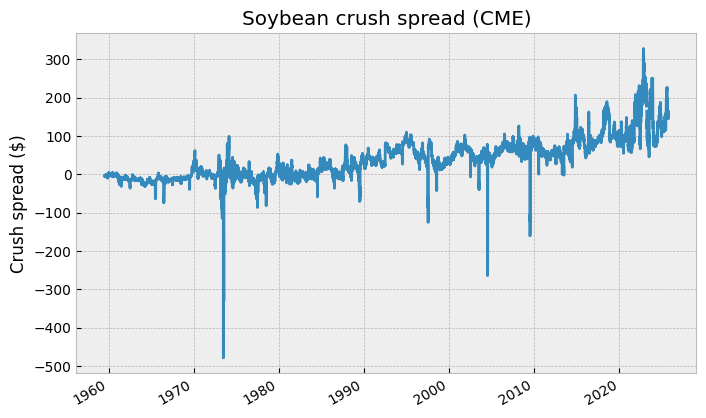

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))
crush_spread_cme.plot();
ax.set_ylabel('Crush spread ($)')
ax.set_title('Soybean crush spread (CME)');

## Backtest

In Simon 1999, the author mentions that the trading strategy is performed in-sample, which suggests that the long-run fair value model was fit with the entire data sample. Because of this, the strategy contains a look-ahead bias and **not a valid trading strategy**. A more appropriate simulation would be to use a walk-forward method such as rolling regression.

### Long-only without the fair value model

One minor but important thing is that in `vivace`, usually futures returns are computed as if they are fully-collateralised. This means effectively, return $r_t$ is computed in the form of 

$$
r_t = \frac{F_t - F_{t-1}}{F_{t-1}}
$$

where $F_t$ is the futures price at time $t$.
This is useful when we want to allocate say an equal amount of dollars across different instruments. However in this notebook, we want to decide the allocation based on the nunmber of  lots for each instrument. This is achieved by calculating returns as follows:

$$
r_t = \frac{F_t - F_{t-1}}{c}
$$

where $c$ is the collateral amount. In the following, some arbitrary collateral of 10,000 is used. By doing this $r_t$ means the return relative to the collateral amount (10k).

With this, let's run the backtest with only long-positions on crush spread are taken, without the fair value model.

In [22]:
common_kwargs = dict(
    start_date=datetime(1985, 1, 1),
    end_date=datetime(1995, 2, 28),
    strategy=Strategy.DELTA_ONE.value,
    instrument=[
        InstrumentDef('S', collateral=10000),
        InstrumentDef('SM', collateral=10000),
        InstrumentDef('BO', collateral=10000),
    ],
    weighting=Weighting.SUM.value,
    log_level=logging.WARN,
)

In [23]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=False,
        long_position=True,
        short_position=False,
    ),
    **common_kwargs,
)
engine.run()

In [24]:
long_only_wo_fair_value = engine.calculate_equity_curve(calculate_net=False)

With more strict entry rule.

In [25]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=300,
        ma_exit=300,
        fair_value=False,
        long_position=True,
        short_position=False,
    ),
    **common_kwargs,
)
engine.run()

In [26]:
long_only_wo_fair_value2 = engine.calculate_equity_curve(calculate_net=False)

In [27]:
levels1 = pd.concat((long_only_wo_fair_value.rename('LO: Entry threshold = $100'), 
                     long_only_wo_fair_value2.rename('LO: Entry threshold = $300')), axis=1)

As reported, having more strict entry rule seems to improve the risk-adjusted returns.

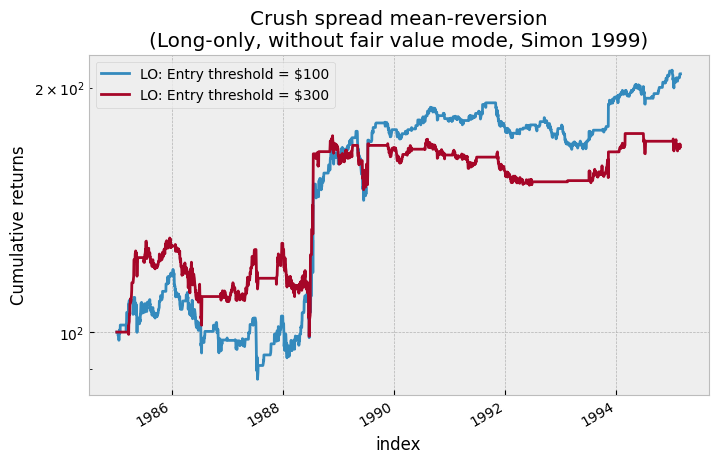

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))
levels1.plot(ax=ax, logy=True);
ax.set_title('Crush spread mean-reversion\n(Long-only, without fair value mode, Simon 1999)')
ax.set_ylabel('Cumulative returns');

In [29]:
levels1.pipe(Performance).summary()

,LO: Entry threshold = $100,LO: Entry threshold = $300
CAGR,0.071983,0.051645
Annualised vol,0.156351,0.159307
Sharpe ratio,0.460396,0.324182
Max drawdown,0.267551,0.243433
Calmar ratio,0.269045,0.212151
Skewness,10.031211,9.024905
Kurtosis,284.999818,207.386493
Worst return,-0.087630,-0.079292
Worst 1d return,-0.087630,-0.079292
Worst 1w return,-0.111127,-0.087580


### Long-only with the fair value model

In [30]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=True,
        fair_value_entry=0,
        long_position=True,
        short_position=False,
    ),
    **common_kwargs,
)
engine.run()

In [31]:
long_only_with_fair_value = engine.calculate_equity_curve(calculate_net=False)

In [32]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=True,
        fair_value_entry=0.1,
        long_position=True,
        short_position=False,
    ),
    **common_kwargs,
)
engine.run()

In [33]:
long_only_with_fair_value2 = engine.calculate_equity_curve(calculate_net=False)

In [34]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=True,
        fair_value_entry=0.2,
        long_position=True,
        short_position=False,
    ),
    **common_kwargs,
)
engine.run()

In [35]:
long_only_with_fair_value3 = engine.calculate_equity_curve(calculate_net=False)

In [36]:
levels2 = pd.concat((long_only_with_fair_value.rename('LO: MA entry = $100, FV entry = 0.0'), 
                     long_only_with_fair_value2.rename('LO: MA entry = $100, FV entry = 0.1'),
                     long_only_with_fair_value3.rename('LO: MA entry = $100, FV entry = 0.2'),), axis=1)

The author tests the fair value threshold of 0.2, however in our analysis this appears to be too strict and the performance is mainly coming from the one-off event in 1988. This suggests that the strategy is sensitive to this parameter and needs to be chosen carefully.

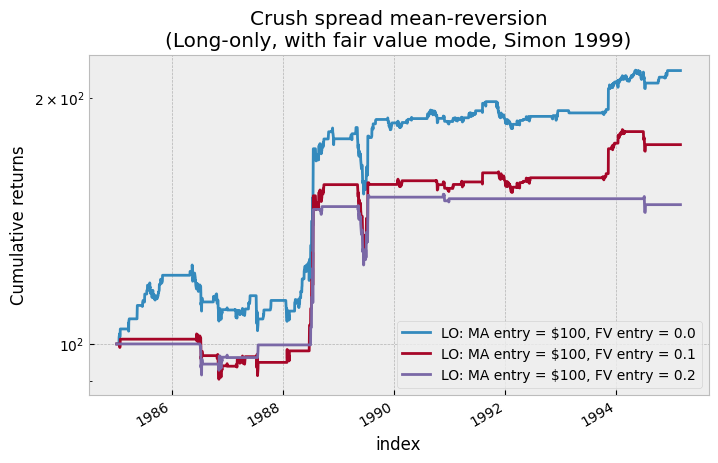

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))
levels2.plot(ax=ax, logy=True);
ax.set_title('Crush spread mean-reversion\n(Long-only, with fair value mode, Simon 1999)')
ax.set_ylabel('Cumulative returns');

In [38]:
levels2.pipe(Performance).summary()

,"LO: MA entry = $100, FV entry = 0.0","LO: MA entry = $100, FV entry = 0.1","LO: MA entry = $100, FV entry = 0.2"
CAGR,0.075673,0.055167,0.038554
Annualised vol,0.122066,0.129802,0.122662
Sharpe ratio,0.619937,0.425010,0.314313
Max drawdown,0.170835,0.167327,0.154081
Calmar ratio,0.442963,0.329698,0.250222
Skewness,13.290572,18.447055,24.765754
Kurtosis,400.525452,610.745311,929.132160
Worst return,-0.075353,-0.087871,-0.091920
Worst 1d return,-0.075353,-0.087871,-0.091920
Worst 1w return,-0.050022,-0.055488,-0.056750


### Short-only without the fair value model

Interestingly, the short-only strategy (short SM, BO and long S) shows better risk-adjusted performance during the same period.

In [39]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=False,
        long_position=False,
        short_position=True,
    ),
    **common_kwargs,
)
engine.run()

In [40]:
short_only_wo_fair_value = engine.calculate_equity_curve(calculate_net=False)

In [41]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=300,
        ma_exit=300,
        fair_value=False,
        long_position=False,
        short_position=True,
    ),
    **common_kwargs,
)
engine.run()

In [42]:
short_only_wo_fair_value2 = engine.calculate_equity_curve(calculate_net=False)

In [43]:
levels3 = pd.concat((short_only_wo_fair_value.rename('SO: Entry threshold = $100'), 
                     short_only_wo_fair_value2.rename('SO: Entry threshold = $300')), axis=1)

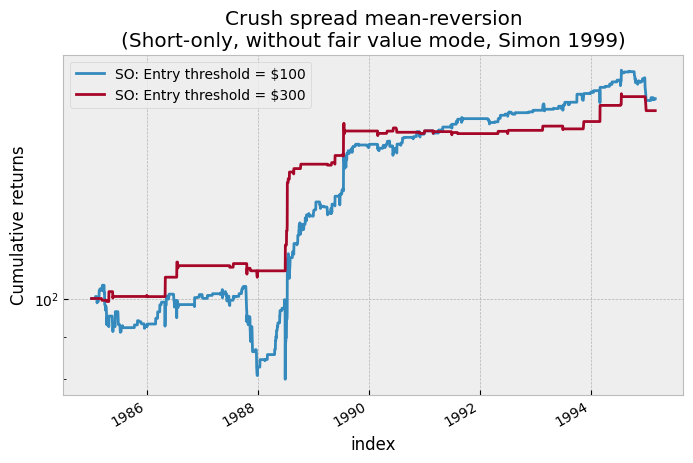

In [44]:
fig, ax = plt.subplots(figsize=(8, 5))
levels3.plot(ax=ax, logy=True);
ax.set_title('Crush spread mean-reversion\n(Short-only, without fair value mode, Simon 1999)')
ax.set_ylabel('Cumulative returns');

In [45]:
levels3.pipe(Performance).summary()

,SO: Entry threshold = $100,SO: Entry threshold = $300
CAGR,0.054269,0.051012
Annualised vol,0.121673,0.066294
Sharpe ratio,0.446019,0.769483
Max drawdown,0.228745,0.045664
Calmar ratio,0.237245,1.117120
Skewness,-0.341875,18.443326
Kurtosis,240.242537,461.438773
Worst return,-0.186560,-0.027590
Worst 1d return,-0.186560,-0.027590
Worst 1w return,-0.117075,-0.038042


### Short-only with the fair value model

In [46]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=True,
        fair_value_entry=0,
        long_position=False,
        short_position=True,
    ),
    **common_kwargs,
)
engine.run()

In [47]:
short_only_with_fair_value = engine.calculate_equity_curve(calculate_net=False)

In [48]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=True,
        fair_value_entry=0.1,
        long_position=False,
        short_position=True,
    ),
    **common_kwargs,
)
engine.run()

In [49]:
short_only_with_fair_value2 = engine.calculate_equity_curve(calculate_net=False)

In [50]:
levels4 = pd.concat((short_only_with_fair_value.rename('SO: MA entry = $100, FV entry = 0.0'), 
                     short_only_with_fair_value2.rename('SO: MA entry = $100, FV entry = 0.1')), axis=1)

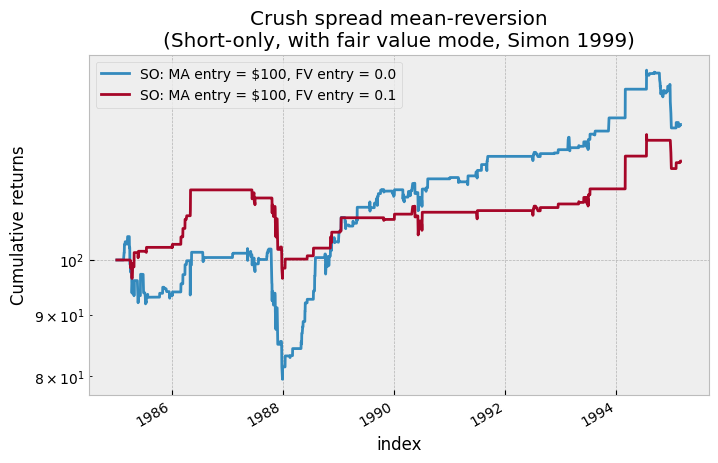

In [51]:
fig, ax = plt.subplots(figsize=(8, 5))
levels4.plot(ax=ax, logy=True);
ax.set_title('Crush spread mean-reversion\n(Short-only, with fair value mode, Simon 1999)')
ax.set_ylabel('Cumulative returns');

In [52]:
levels4.pipe(Performance).summary()

,"SO: MA entry = $100, FV entry = 0.0","SO: MA entry = $100, FV entry = 0.1"
CAGR,0.025545,0.018642
Annualised vol,0.074679,0.051233
Sharpe ratio,0.342068,0.363873
Max drawdown,0.239363,0.156052
Calmar ratio,0.106722,0.119462
Skewness,0.499456,5.146409
Kurtosis,46.297481,116.334033
Worst return,-0.063592,-0.028604
Worst 1d return,-0.063592,-0.028604
Worst 1w return,-0.070740,-0.057013


## Long-term performance

In this section, out-of-sample performance is calculated. To be consistent with the previous section, the fair value model is fit using data up to Feb-1995.

In [53]:
common_kwargs = dict(
    start_date=datetime(1985, 1, 1),
    strategy=Strategy.DELTA_ONE.value,
    instrument=[
        InstrumentDef('S', collateral=10000),
        InstrumentDef('SM', collateral=10000),
        InstrumentDef('BO', collateral=10000),
    ],
    weighting=Weighting.SUM.value,
    log_level=logging.WARN,
)

### Long-only without the fair value model

In [54]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=False,
        long_position=True,
        short_position=False,
    ),
    **common_kwargs,
)
engine.run()

In [55]:
long_only_wo_fair_value = engine.calculate_equity_curve(calculate_net=False)

In [56]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=300,
        ma_exit=300,
        fair_value=False,
        long_position=True,
        short_position=False,
    ),
    **common_kwargs,
)
engine.run()

In [57]:
long_only_wo_fair_value2 = engine.calculate_equity_curve(calculate_net=False)

In [58]:
levels1 = pd.concat((long_only_wo_fair_value.rename('LO: Entry threshold = $100'), 
                     long_only_wo_fair_value2.rename('LO: Entry threshold = $300')), axis=1)

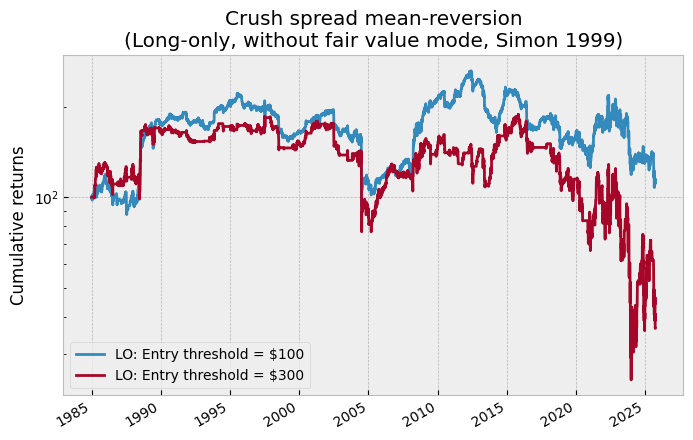

In [59]:
fig, ax = plt.subplots(figsize=(8, 5))
levels1.plot(ax=ax, logy=True);
ax.set_title('Crush spread mean-reversion\n(Long-only, without fair value mode, Simon 1999)')
ax.set_ylabel('Cumulative returns');

In [60]:
levels1.pipe(Performance).summary()

,LO: Entry threshold = $100,LO: Entry threshold = $300
CAGR,0.002556,-0.024652
Annualised vol,0.156136,0.267430
Sharpe ratio,0.016368,-0.092182
Max drawdown,0.591010,0.869203
Calmar ratio,0.004324,-0.028362
Skewness,1.479655,0.034874
Kurtosis,98.173984,39.154720
Worst return,-0.174846,-0.204579
Worst 1d return,-0.174846,-0.204579
Worst 1w return,-0.283373,-0.316319


### Long-only with the fair value model

In [61]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=True,
        fair_value_entry=0,
        fair_value_end_date=datetime(1995, 2, 28),
        long_position=True,
        short_position=False,
    ),
    **common_kwargs,
)
engine.run()

In [62]:
long_only_with_fair_value = engine.calculate_equity_curve(calculate_net=False)

In [63]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=True,
        fair_value_entry=0.1,
        fair_value_end_date=datetime(1995, 2, 28),
        long_position=True,
        short_position=False,
    ),
    **common_kwargs,
)
engine.run()

In [64]:
long_only_with_fair_value2 = engine.calculate_equity_curve(calculate_net=False)

In [65]:
levels2 = pd.concat((long_only_with_fair_value.rename('LO: MA entry = $100, FV entry = 0.0'), 
                     long_only_with_fair_value2.rename('LO: MA entry = $100, FV entry = 0.1')), axis=1)

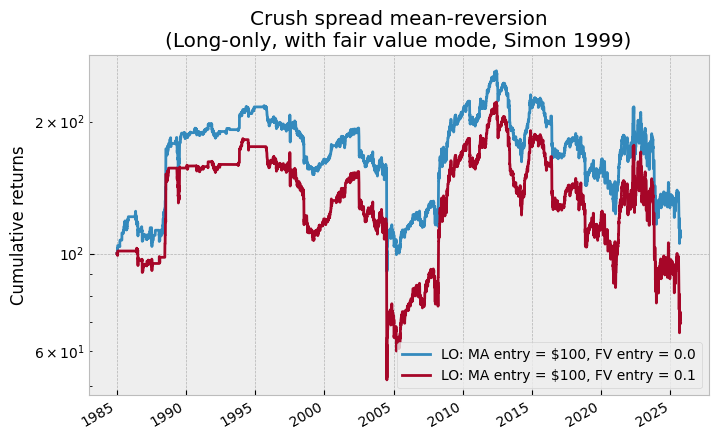

In [66]:
fig, ax = plt.subplots(figsize=(8, 5))
levels2.plot(ax=ax, logy=True);
ax.set_title('Crush spread mean-reversion\n(Long-only, with fair value mode, Simon 1999)')
ax.set_ylabel('Cumulative returns');

In [67]:
levels2.pipe(Performance).summary()

,"LO: MA entry = $100, FV entry = 0.0","LO: MA entry = $100, FV entry = 0.1"
CAGR,0.002063,-0.009014
Annualised vol,0.149900,0.198733
Sharpe ratio,0.013760,-0.045358
Max drawdown,0.596003,0.718188
Calmar ratio,0.003461,-0.012551
Skewness,0.552507,-0.142402
Kurtosis,77.568144,80.721179
Worst return,-0.178304,-0.276053
Worst 1d return,-0.178304,-0.276053
Worst 1w return,-0.287367,-0.384355


### Short-only without the fair value model

In [68]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=False,
        long_position=False,
        short_position=True,
    ),
    **common_kwargs,
)
engine.run()

In [69]:
short_only_wo_fair_value = engine.calculate_equity_curve(calculate_net=False)

In [70]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=300,
        ma_exit=300,
        fair_value=False,
        long_position=False,
        short_position=True,
    ),
    **common_kwargs,
)
engine.run()

In [71]:
short_only_wo_fair_value2 = engine.calculate_equity_curve(calculate_net=False)

In [72]:
levels3 = pd.concat((short_only_wo_fair_value.rename('SO: Entry threshold = $100'), 
                     short_only_wo_fair_value2.rename('SO: Entry threshold = $300')), axis=1)

Again, interestingly, short-only strategy performed well in the out-of-sample period. However it started to underperform since around 2013.

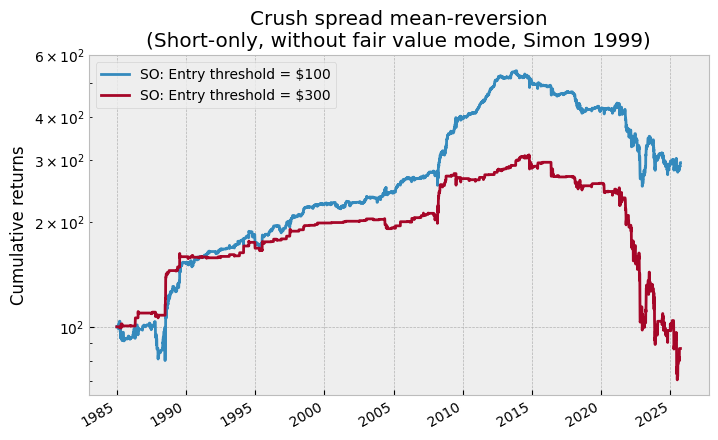

In [73]:
fig, ax = plt.subplots(figsize=(8, 5))
levels3.plot(ax=ax, logy=True);
ax.set_title('Crush spread mean-reversion\n(Short-only, without fair value mode, Simon 1999)')
ax.set_ylabel('Cumulative returns');

In [74]:
levels3.pipe(Performance).summary()

,SO: Entry threshold = $100,SO: Entry threshold = $300
CAGR,0.026622,-0.003521
Annualised vol,0.086049,0.104553
Sharpe ratio,0.309387,-0.033675
Max drawdown,0.533556,0.773635
Calmar ratio,0.049896,-0.004551
Skewness,0.117661,-1.127757
Kurtosis,260.777787,179.276489
Worst return,-0.186560,-0.204126
Worst 1d return,-0.186560,-0.204126
Worst 1w return,-0.117075,-0.209328


### Short-only with the fair value model

In [75]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=True,
        fair_value_entry=0,
        fair_value_end_date=datetime(1995, 2, 28),
        long_position=False,
        short_position=True,
    ),
    **common_kwargs,
)
engine.run()

In [76]:
short_only_with_fair_value = engine.calculate_equity_curve(calculate_net=False)

In [77]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=True,
        fair_value_entry=0.1,
        fair_value_end_date=datetime(1995, 2, 28),
        long_position=False,
        short_position=True,
    ),
    **common_kwargs,
)
engine.run()

In [78]:
short_only_with_fair_value2 = engine.calculate_equity_curve(calculate_net=False)

In [79]:
levels4 = pd.concat((short_only_with_fair_value.rename('SO: MA entry = $100, FV entry = 0.0'), 
                     short_only_with_fair_value2.rename('SO: MA entry = $100, FV entry = 0.1')), axis=1)

The fair value model almost stopped taking positions in the out-of-sample period because the regression redisual started to drift away from zero. This suggests that the model needs to be refit on a rolling basis.

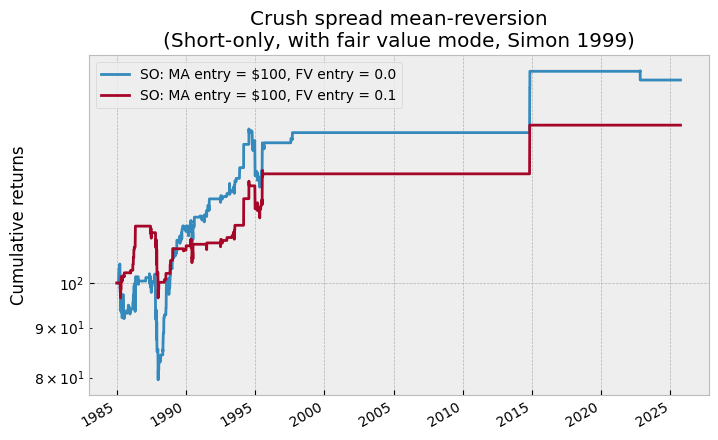

In [80]:
fig, ax = plt.subplots(figsize=(8, 5))
levels4.plot(ax=ax, logy=True);
ax.set_title('Crush spread mean-reversion\n(Short-only, with fair value mode, Simon 1999)')
ax.set_ylabel('Cumulative returns');

In [81]:
levels4.pipe(Performance).summary()

,"SO: MA entry = $100, FV entry = 0.0","SO: MA entry = $100, FV entry = 0.1"
CAGR,0.011776,0.009159
Annualised vol,0.041916,0.031770
Sharpe ratio,0.280952,0.288297
Max drawdown,0.239363,0.156052
Calmar ratio,0.049199,0.058694
Skewness,4.522775,15.759523
Kurtosis,214.158961,579.830843
Worst return,-0.063592,-0.028604
Worst 1d return,-0.063592,-0.028604
Worst 1w return,-0.070740,-0.057013


# Post publication

In [82]:
publication_date = datetime(1999, 4, 27)

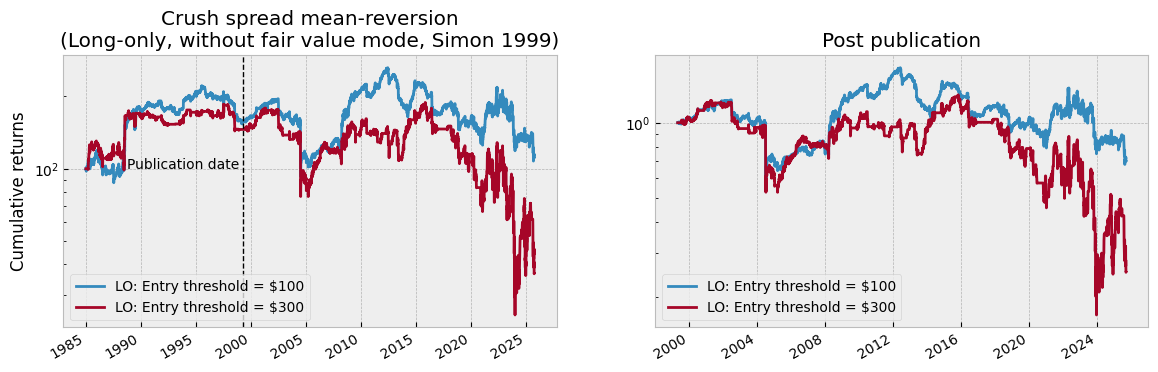

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
levels1.plot(ax=ax[0], logy=True);
ax[0].set_title('Crush spread mean-reversion\n(Long-only, without fair value mode, Simon 1999)')
ax[0].set_ylabel('Cumulative returns');
ax[0].axvline(publication_date, lw=1, ls='--', color='black')
ax[0].text(publication_date, 100, 'Publication date ', ha='right')

levels1.loc[publication_date:].pipe(rebase).plot(ax=ax[1], logy=True);
ax[1].set_title('Post publication');

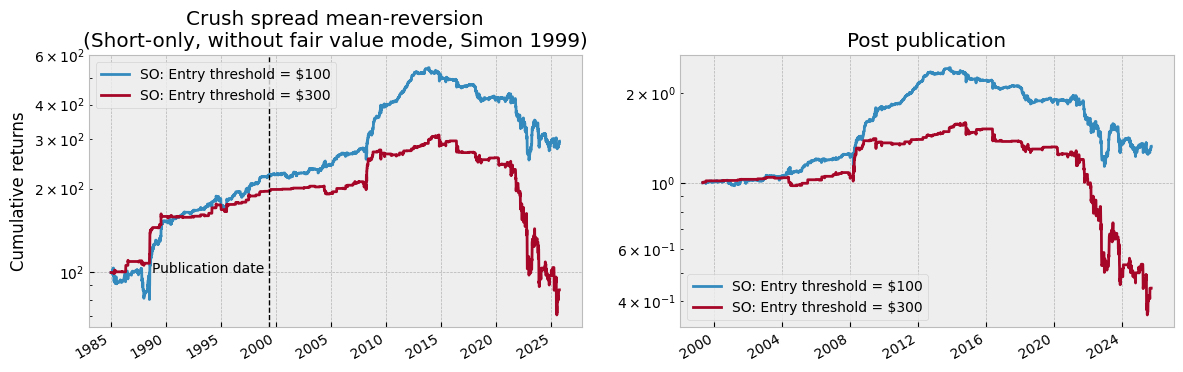

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
levels3.plot(ax=ax[0], logy=True);
ax[0].set_title('Crush spread mean-reversion\n(Short-only, without fair value mode, Simon 1999)')
ax[0].set_ylabel('Cumulative returns');
ax[0].axvline(publication_date, lw=1, ls='--', color='black')
ax[0].text(publication_date, 100, 'Publication date ', ha='right')

levels3.loc[publication_date:].pipe(rebase).plot(ax=ax[1], logy=True);
ax[1].set_title('Post publication');

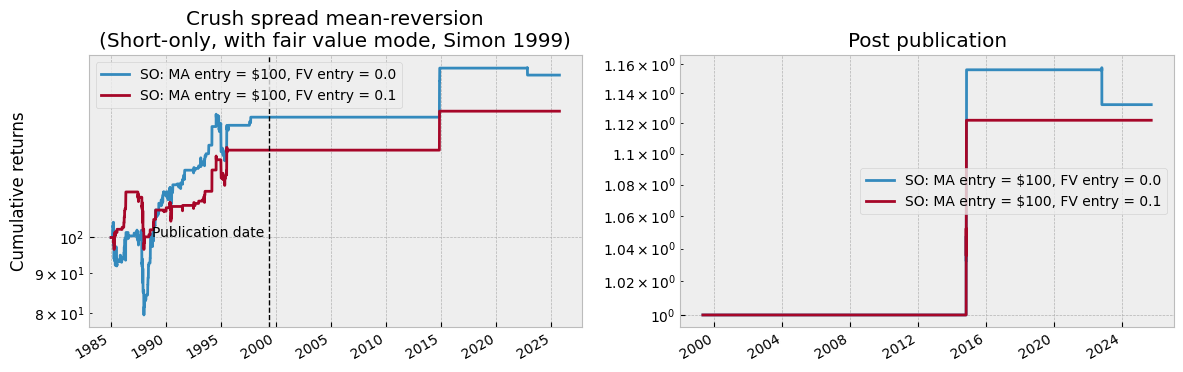

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
levels4.plot(ax=ax[0], logy=True);
ax[0].set_title('Crush spread mean-reversion\n(Short-only, with fair value mode, Simon 1999)')
ax[0].set_ylabel('Cumulative returns');
ax[0].axvline(publication_date, lw=1, ls='--', color='black')
ax[0].text(publication_date, 100, 'Publication date ', ha='right')

levels4.loc[publication_date:].pipe(rebase).plot(ax=ax[1], logy=True);
ax[1].set_title('Post publication');

# Seasonality

In the regression analysis, we saw that the crush spread tended to be higher in the growing season, and lower in winter. Let's see if this pattern can be captured in a simple long/short strategy.

In [86]:
soybean_1st = BacktestEngine(instrument=InstrumentDef('S', collateral=10000), log_level=logging.WARN)
soybean_1st.run()

In [87]:
soybean_meal_1st = BacktestEngine(instrument=InstrumentDef('SM', collateral=10000), log_level=logging.WARN)
soybean_meal_1st.run()

In [88]:
soybean_oil_1st = BacktestEngine(instrument=InstrumentDef('BO', collateral=10000), log_level=logging.WARN)
soybean_oil_1st.run()

`crush_spread_return` contains returns of a long position in the crush spread (1 lot each).

In [89]:
crush_spread_return = pd.concat((
    soybean_meal_1st.get_return(calculate_net=False).mul(100),
    soybean_oil_1st.get_return(calculate_net=False).mul(600),
    soybean_1st.get_return(calculate_net=False).mul(-50),
), axis=1).fillna(0).sum(axis=1)

In [90]:
seasonality = crush_spread_return.to_frame('return').assign(
    growing=lambda df: -1 * df['return'].where((df.index.month >= 2) & (df.index.month <= 6)),
    winter=lambda df: df['return'].where((df.index.month >= 9) & (df.index.month <= 11)),
).fillna(0).assign(
    long_short=lambda df: df['growing'] + df['winter']
).add(1).cumprod().rename(columns={
    'return': 'Unconditional long',
    'growing': 'Short growing season',
    'winter': 'Long winter',
    'long_short': 'Short growing season + long winter',
})

The result is consistent with the regression, however it doesn't look a very attractive strategy.

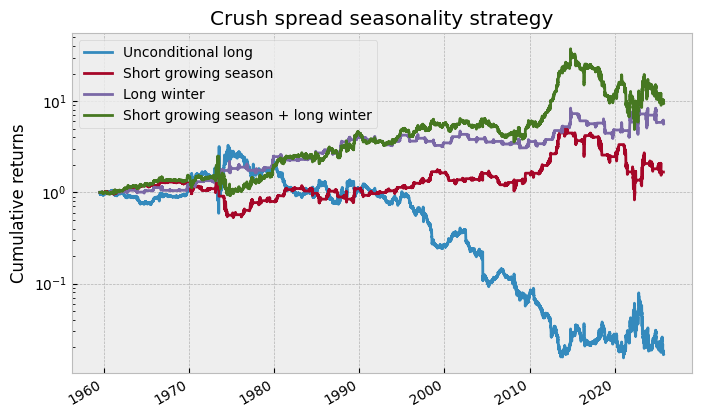

In [91]:
fig, ax = plt.subplots(figsize=(8, 5))

seasonality.plot(ax=ax, logy=True);
ax.set_title('Crush spread seasonality strategy')
ax.set_ylabel('Cumulative returns');

In [92]:
seasonality.pipe(Performance).summary()

,Unconditional long,Short growing season,Long winter,Short growing season + long winter
CAGR,-0.061895,0.007746,0.026006,0.033752
Annualised vol,0.344335,0.222066,0.154790,0.270672
Sharpe ratio,-0.179752,0.034880,0.168008,0.124699
Max drawdown,0.995326,0.837702,0.535730,0.869905
Calmar ratio,-0.062186,0.009246,0.048543,0.038800
Skewness,0.609652,-0.633623,0.401549,-0.300133
Kurtosis,41.026090,73.187032,58.604262,38.116338
Worst return,-0.364000,-0.351800,-0.178450,-0.351800
Worst 1d return,-0.364000,-0.351800,-0.178450,-0.351800
Worst 1w return,-0.414468,-0.510224,-0.298939,-0.510224


# Note
- As mentioned above, the fair value model is fit using data until Feb-1995. This means the performance before this period is in-sample and hence not a valid trading strategy
- The trading strategy appears to be highly sensitive to the threshold for the fair value model
- The regression and backtest suggest that the fair value model is time-varying which means the model needs to be refit on a regular basis

# Reference
- Mitchell, J.B., 2010. Soybean futures crush spread arbitrage: Trading strategies and market efficiency. Journal of Risk and Financial Management, 3(1), pp.63-96.
- Simon, D.P., 1999. The soybean crush spread: Empirical evidence and trading strategies. Journal of Futures Markets: Futures, Options, and Other Derivative Products, 19(3), pp.271-289.

In [93]:
print(f'Updated: {datetime.now(pytz.utc):%d-%b-%Y %H:%M}')

Updated: 26-Sep-2025 10:45
